In [ ]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from prophet import Prophet

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
data = pd.read_csv('./meta.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,2012-05-18,42.05,45.00,38.00,38.2318,573576400
1,2012-05-21,36.53,36.66,33.00,34.0300,168192700
2,2012-05-22,32.61,33.59,30.94,31.0000,101786600
3,2012-05-23,31.37,32.50,31.36,32.0000,73600000
4,2012-05-24,32.95,33.21,31.77,33.0300,50237200


In [35]:
# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


In [36]:
# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Volatility (Standard Deviation): Capture price fluctuations:
# for ma in ma_day:
#     column_name = f"Volatility_{ma}d"
#     data[column_name] = data['Close'].rolling(window=ma).std()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# # Trading Volume Moving Average: Add moving averages for the Volume
# for ma in ma_day:
#     data[f"Volume_MA_{ma}"] = data['Volume'].rolling(window=ma).mean()



            Date    Open     High       Low     Close     Volume  \
0     2012-05-18   42.05   45.000   38.0000   38.2318  573576400   
1     2012-05-21   36.53   36.660   33.0000   34.0300  168192700   
2     2012-05-22   32.61   33.590   30.9400   31.0000  101786600   
3     2012-05-23   31.37   32.500   31.3600   32.0000   73600000   
4     2012-05-24   32.95   33.210   31.7700   33.0300   50237200   
...          ...     ...      ...       ...       ...        ...   
2668  2022-12-23  116.03  118.175  115.5350  118.0400   17796625   
2669  2022-12-27  117.93  118.600  116.0501  116.8800   21392311   
2670  2022-12-28  116.25  118.150  115.5100  115.6200   19612473   
2671  2022-12-29  116.40  121.030  115.7700  120.2600   22366192   
2672  2022-12-30  118.16  120.420  117.7400  120.3400   19583825   

      MA for 5 days  MA for 10 days  MA for 20 days  MA for 50 days  \
0               NaN             NaN             NaN             NaN   
1               NaN             NaN      

,count,mean,std,min,25%,50%,75%,max
Open,2673.0,1.479633e+02,8.696828e+01,1.808000e+01,7.780000e+01,1.422600e+02,1.913600e+02,3.816800e+02
High,2673.0,1.498468e+02,8.805465e+01,1.827000e+01,7.853000e+01,1.445600e+02,1.940300e+02,3.843300e+02
Low,2673.0,1.460862e+02,8.591529e+01,1.755000e+01,7.705000e+01,1.408700e+02,1.884700e+02,3.788100e+02
Close,2673.0,1.479917e+02,8.699929e+01,1.772900e+01,7.783000e+01,1.422800e+02,1.912900e+02,3.821800e+02
Volume,2673.0,3.115405e+07,2.721709e+07,5.913066e+06,1.618928e+07,2.313342e+07,3.599420e+07,5.735764e+08
MA for 5 days,2669.0,1.480981e+02,8.692966e+01,1.846140e+01,7.780600e+01,1.422620e+02,1.913780e+02,3.790300e+02
MA for 10 days,2664.0,1.482359e+02,8.686269e+01,1.877955e+01,7.777912e+01,1.418685e+02,1.917312e+02,3.786580e+02
MA for 20 days,2654.0,1.485193e+02,8.673551e+01,1.925918e+01,7.751544e+01,1.434165e+02,1.920813e+02,3.734220e+02
MA for 50 days,2624.0,1.493997e+02,8.630554e+01,2.017572e+01,7.745560e+01,1.471485e+02,1.906790e+02,3.637544e+02
EMA for 5 days,2673.0,1.479314e+02,8.694024e+01,1.846579e+01,7.757111e+01,1.420655e+02,1.913073e+02,3.782458e+02


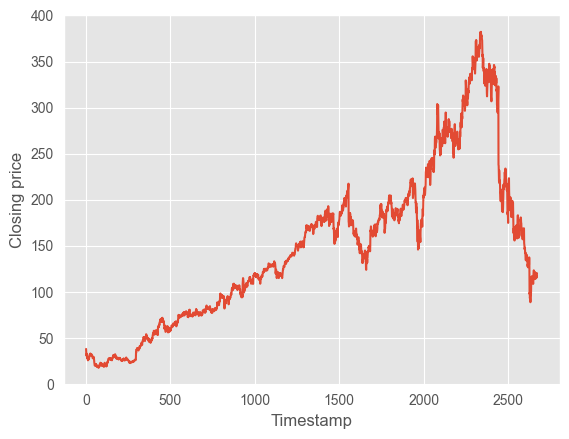

In [6]:
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
df = data
print(df)

df.describe().transpose()

In [37]:
data.dropna(inplace=True)
data.head(500)

,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,71.536342


In [38]:
# Load and preprocess data
import pandas as pd
import numpy as np

data = pd.read_csv('./meta.csv')
data.reset_index(drop=True, inplace=True)

# Handle missing values
numeric_data = data.select_dtypes(include=[np.number])
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Add moving averages and RSI
ma_day = [5, 10, 20, 50]
for ma in ma_day:
    data[f"MA_{ma}"] = data['Close'].rolling(window=ma).mean()
    data[f"EMA_{ma}"] = data['Close'].ewm(span=ma, adjust=False).mean()

data['RSI_14'] = compute_RSI(data)

# Drop NaN rows created by rolling/EMA operations
data.dropna(inplace=True)

# Ensure Prophet compatibility: columns should be 'ds' and 'y'
data = data.rename(columns={'Date': 'ds', 'Close': 'y'})


In [39]:
# Load and preprocess data
data = pd.read_csv('./meta.csv')

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Calculate moving average
ma_day = [5, 10, 20, 50]
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# Drop NaN values
data.dropna(inplace=True)

In [40]:
# Split data into train and test
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Prepare data for Prophet
train_prophet = train_data[['Date', 'Close']].copy()
train_prophet.columns = ['ds', 'y']

test_prophet = test_data[['Date', 'Close']].copy()
test_prophet.columns = ['ds', 'y']

# Train Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(train_prophet)

# Get Prophet predictions for both train and test sets
train_prophet_pred = prophet_model.predict(train_prophet)
test_prophet_pred = prophet_model.predict(test_prophet)

# Calculate residuals
train_residuals = train_data['Close'].values - train_prophet_pred['yhat'].values
test_residuals = test_data['Close'].values - test_prophet_pred['yhat'].values

23:13:33 - cmdstanpy - INFO - Chain [1] start processing
23:13:34 - cmdstanpy - INFO - Chain [1] done processing


In [41]:
# Create sequences for LSTM using residuals
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 100
X_train, y_train = create_sequences(train_residuals, window_size)
X_test, y_test = create_sequences(test_residuals, window_size)

# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build and train LSTM model for residuals
lstm_model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Train LSTM
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Get LSTM predictions for residuals
lstm_train_pred = lstm_model.predict(X_train)
lstm_test_pred = lstm_model.predict(X_test)

# Combine predictions
train_predictions = train_prophet_pred['yhat'][window_size:].values + lstm_train_pred.flatten()
test_predictions = test_prophet_pred['yhat'][window_size:].values + lstm_test_pred.flatten()

# Get actual values
train_actual = train_data['Close'][window_size:].values
test_actual = test_data['Close'][window_size:].values


c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 78.3666 - mae: 5.4693 - mse: 78.3666 - val_loss: 16767.3535 - val_mae: 99.2740 - val_mse: 16767.3535
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 29.5886 - mae: 2.8402 - mse: 29.5886 - val_loss: 14283.2744 - val_mae: 89.9821 - val_mse: 14283.2744
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 14.4456 - mae: 2.2543 - mse: 14.4456 - val_loss: 12938.9219 - val_mae: 83.9552 - val_mse: 12938.9219
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 12.8716 - mae: 2.2115 - mse: 12.8716 - val_loss: 12950.5703 - val_mae: 83.4556 - val_mse: 12950.5703
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 13.3408 - mae: 2.2543 - mse: 13.3408 - val_loss: 11766.9902 - val_mae: 78.7993 - val_mse: 11766.9902
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 11.7169 - mae: 2.1514 - mse: 11.7169 - val_loss: 11296.8682 - val_mae: 76.6237 - val_mse: 11296.8682
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━

In [26]:
# Create sequences for LSTM
window_size = 100
X = []
Y = []

for i in range(1, len(data) - window_size - 1, 1):
    first_close = data.iloc[i]['Close']
    temp = []
    temp2 = []
    
    for j in range(window_size):
        normalized_close = (data.iloc[i + j]['Close'] - first_close) / first_close
        rsi_14 = data.iloc[i + j]['RSI_14']
        temp.append([normalized_close, rsi_14])
        
    temp2.append((data.iloc[i + window_size]['Close'] - first_close) / first_close)
    X.append(np.array(temp))
    Y.append(np.array(temp2).reshape(1, 1))

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Reshape for LSTM
train_X = x_train.reshape(x_train.shape[0], x_train.shape[1], 2)
test_X = x_test.reshape(x_test.shape[0], x_test.shape[1], 2)

# Build LSTM model
model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(window_size, 2)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Train LSTM model
history = model.fit(
    train_X, y_train,
    validation_data=(test_X, y_test),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.1177 - mae: 0.2564 - mse: 0.1177 - val_loss: 0.0342 - val_mae: 0.1184 - val_mse: 0.0342
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0465 - mae: 0.1579 - mse: 0.0465 - val_loss: 0.0229 - val_mae: 0.0991 - val_mse: 0.0229
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0258 - mae: 0.1169 - mse: 0.0258 - val_loss: 0.0317 - val_mae: 0.1571 - val_mse: 0.0317
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0231 - mae: 0.1163 - mse: 0.0231 - val_loss: 0.0138 - val_mae: 0.0997 - val_mse: 0.0138
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0108 - mae: 0.0809 - mse: 0.0108 - val_loss: 0.0038 - val_mae: 0.0473 - val_mse: 0.0038
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0069 - mae: 0.0636 - mse: 0.0069 - val_loss: 0.0136 - val_mae: 0.1064 - val_mse: 0.0136
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0076 - mae: 0.0682 - mse: 0.0076 - val_loss: 0.0046 -

In [27]:
# Prepare Prophet data
prophet_df = data[['Date', 'Close']].copy()
prophet_df.columns = ['ds', 'y']

# Initialize and train Prophet model
prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet.fit(prophet_df)


22:05:27 - cmdstanpy - INFO - Chain [1] start processing
22:05:28 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Make predictions
# Calculate train size for denormalization
train_size = int(len(data) * 0.8)

# Get LSTM predictions
lstm_predictions = model.predict(test_X)
test_label = y_test.reshape(-1, 1)
predicted = np.array(lstm_predictions[:, 0]).reshape(-1, 1)

# Denormalize predictions
for j in range(len(predicted)):
    idx = train_size + j
    temp = data.iloc[idx]['Close']
    test_label[j] = test_label[j] * temp + temp
    predicted[j] = predicted[j] * temp + temp


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


IndexError: index 425 is out of bounds for axis 0 with size 425

In [29]:
# Get Prophet predictions for the test period
future_df = prophet_df.iloc[train_size:train_size + len(predicted)]
prophet_forecast = prophet.predict(future_df)
prophet_predictions = prophet_forecast['yhat'].values

# Combine predictions
final_predictions = predicted.flatten() + prophet_predictions

# Create results DataFrame
results = pd.DataFrame({
    'Date': data['Date'].values[train_size:train_size + len(predicted)],
    'Actual': test_label.flatten(),
    'Forecast': final_predictions,
    'Prophet_Trend': prophet_forecast['trend'],
    'Lower_Bound': prophet_forecast['yhat_lower'],
    'Upper_Bound': prophet_forecast['yhat_upper']
})

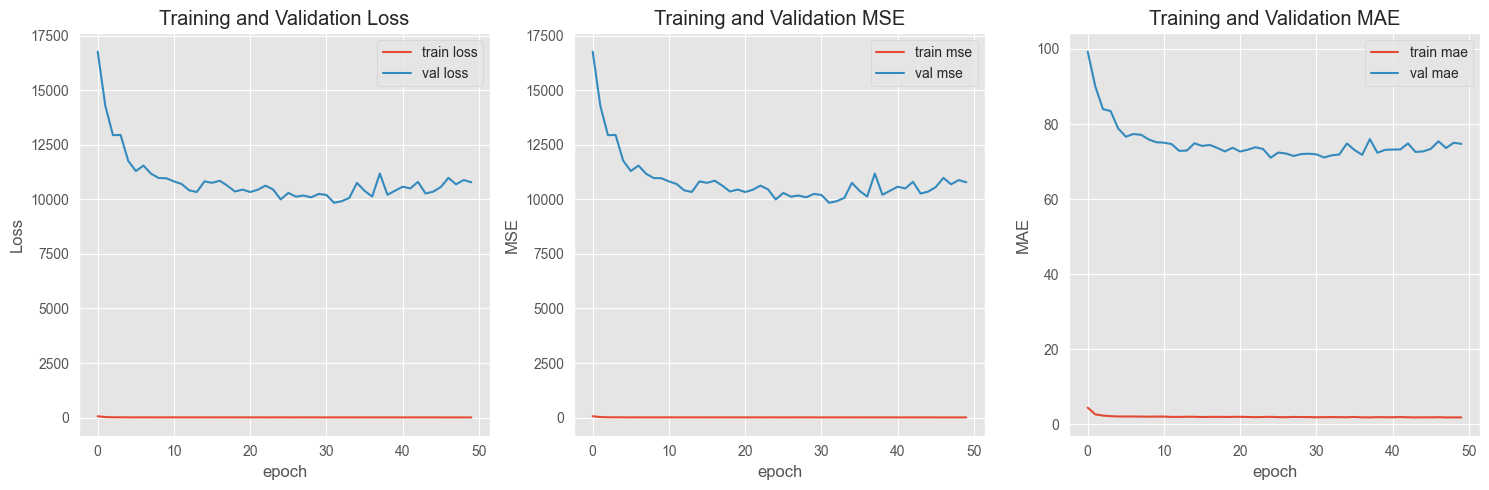


Model Performance Metrics:
MSE: 62259.8630
RMSE: 249.5193
MAE: 244.9690
R2: -4.0725
MAPE: 97.8910%


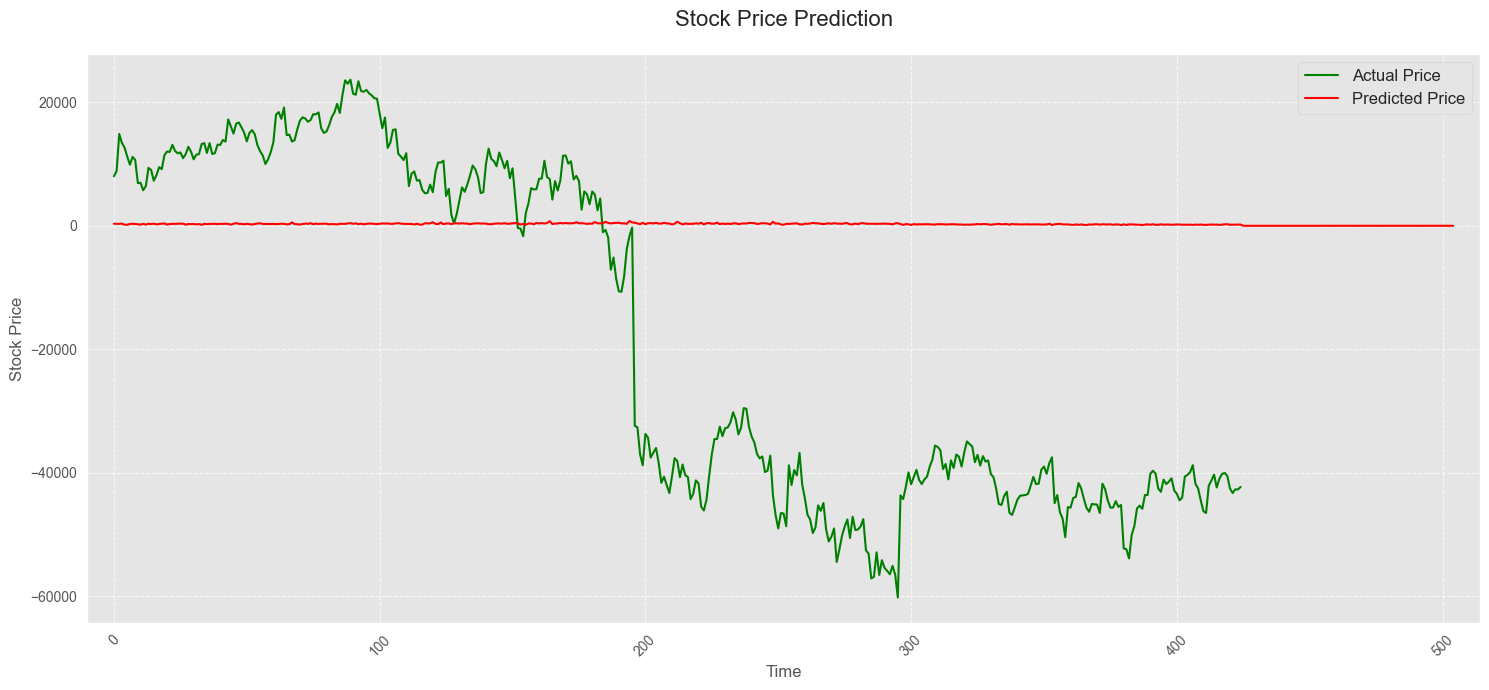

In [43]:
# Plot training metrics
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# MSE plot
plt.subplot(1, 3, 2)
plt.plot(history.history['mse'], label='train mse')
plt.plot(history.history['val_mse'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.title("Training and Validation MSE")
plt.legend()
plt.grid(True)

# MAE plot
plt.subplot(1, 3, 3)
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

def plot_predictions(test_label, predicted, title="Stock Price Prediction"):
    # Create figure and axis with specified size
    plt.figure(figsize=(15, 7))
    
    # Plot actual prices
    plt.plot(test_label, label='Actual Price', color='green')
    
    # Plot predicted prices
    plt.plot(predicted, label='Predicted Price', color='red')
    
    # Customize the plot
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Stock Price', fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add margins for better visibility
    plt.margins(x=0.02)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show plot
    plt.show()

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(results['Actual'], results['Forecast'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results['Actual'], results['Forecast'])
r2 = r2_score(results['Actual'], results['Forecast'])
mape = np.mean(np.abs((results['Actual'] - results['Forecast']) / results['Actual'])) * 100

print("\nModel Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAPE: {mape:.4f}%")

# Plot predictions
plot_predictions(test_label,predicted)